LER ARTIGO DO UNIVERSAL E CST GAN E VER QUAIS MÉTRICAS ELES USAM E APLICAR AQUI!!!!!!!!

In [45]:
%load_ext autoreload
%autoreload 2

import os
import sys
import random
import joblib
from pathlib import Path
from aerosandbox import Airfoil, KulfanAirfoil

# Find the project root (the nearest ancestor that contains `src`) and add it to sys.path
cwd = Path.cwd()
project_root = cwd
for _ in range(6):
    if (project_root / "src").exists():
        break
    if project_root.parent == project_root:
        break
    project_root = project_root.parent
else:
    project_root = cwd

proj_path = str(project_root.resolve())
if proj_path not in sys.path:
    # Insert at front so local packages take precedence
    sys.path.insert(0, proj_path)

import tensorflow as tf
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import wandb
from tqdm import tqdm

from src.vae import CSTVariationalAutoencoder
from src.utils import plot_original_and_reconstruction
from src.layers.airfoil_scaler import AirfoilScaler

from src.airfoil import airfoil_modifications

SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
# ============================================================================
# USER INPUTS
# ============================================================================

# 1. The timestamp folder name in models/cstvae/
RUN_ID = "20260131-184537"  

# 2. The specific epoch number to load
EPOCH = 500                 

# 3. Model Hyperparameters (Must match what was used in training)
NPV = 12
LATENT_DIM = 16

# 4. Number of airfoils to plot during validation
AIRFOILS_TO_PLOT = 16

# Paths
BASE_DIR = Path(proj_path) # Project Root
MODELS_DIR = BASE_DIR / "models" / "cstvae" / RUN_ID
WEIGHTS_PATH = MODELS_DIR / "weights" / f"vae_weights_epoch_{EPOCH}.weights.h5"
SCALER_PATH = MODELS_DIR / "scaler" / "scaler.pkl"
DATA_PATH = BASE_DIR / "data" / "processed" / "val_kulfan_dataset_75.json"

print(f"Loading model from: {RUN_ID}")
print(f"Weights file: {WEIGHTS_PATH}")

Loading model from: 20260131-184537
Weights file: /home/matsouto/py/Generative_airfoil_models/models/cstvae/20260131-184537/weights/vae_weights_epoch_500.weights.h5


In [47]:
# 1. Load the Scaler
if not SCALER_PATH.exists():
    raise FileNotFoundError(f"Scaler not found at {SCALER_PATH}")

print("Loading Scaler...")
scaler = joblib.load(SCALER_PATH)

# 2. Instantiate the VAE Model
print("Building VAE Architecture...")
vae = CSTVariationalAutoencoder(scaler=scaler, npv=NPV, latent_dim=LATENT_DIM)

# 3. Run a dummy forward pass to initialize the graph
# (TensorFlow needs to know input shape to build layers before loading weights)
dummy_input = tf.zeros((1, 26)) 
vae(dummy_input)

# 4. Load Weights
print(f"Loading Weights from Epoch {EPOCH}...")
try:
    vae.load_weights(WEIGHTS_PATH)
    print("✓ Weights loaded successfully.")
except OSError as e:
    print(f"❌ Error loading weights: {e}")
    print("Check if the file path is correct.")

Loading Scaler...
Building VAE Architecture...
Loading Weights from Epoch 500...
✓ Weights loaded successfully.


/home/matsouto/py/Generative_airfoil_models/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:424: UserWarning: `build()` was called on layer 'encoder_8', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/matsouto/py/Generative_airfoil_models/.venv/lib/python3.12/site-packages/keras/src/layers/layer.py:424: UserWarning: `build()` was called on layer 'decoder_8', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


In [48]:
# 1. Load Dataframe
print("Loading Validation Dataset...")
val_df = pd.read_json(DATA_PATH)

# 2. Select First 9 Airfoils
val_sample = val_df.iloc[:AIRFOILS_TO_PLOT].copy().reset_index(drop=True)

# 3. Helper to format coordinates
val_sample["coordinates"] = val_sample["coordinates"].apply(np.array)

# 4. Extract Kulfan Parameters (Exact logic from train.py)
# Note: Ensure order (lower vs upper) matches your training script exactly
raw_vectors = val_sample["kulfan_parameters"].apply(
  lambda p: np.concatenate([
    p["lower_weights"],     # Lower
    p["upper_weights"],     # Upper
    [p["TE_thickness"]],    # TE
    [p["leading_edge_weight"]] # LE
    ], axis=0)).to_list()

# 5. Normalize
raw_tensor = tf.convert_to_tensor(raw_vectors, dtype=tf.float32)
weights_raw = raw_tensor[:, :24]
params_raw = raw_tensor[:, 24:]
input_normalized = scaler.transform(weights_raw, params_raw)

print(f"✓ Data prepared. Input shape: {input_normalized.shape}")

Loading Validation Dataset...
✓ Data prepared. Input shape: (16, 26)


Running Inference...
Preparing Airfoil objects...
Generating Plots...


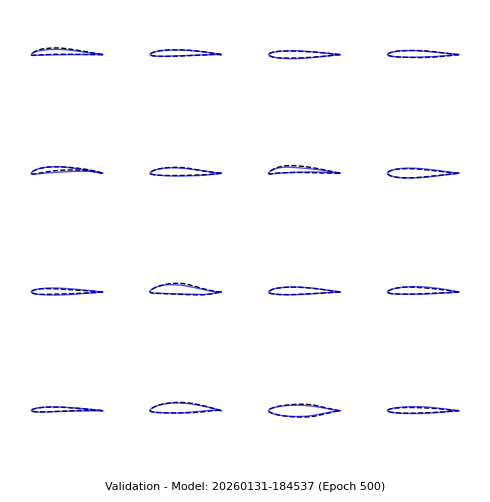

In [49]:
# 1. Run Inference (Reconstruction)
print("Running Inference...")
# training=False removes stochastic noise for validation
_, pred_weights_norm, pred_params_norm = vae(input_normalized, training=False)

# 2. Denormalize Predictions
pred_weights, pred_params = scaler.inverse_transform(
    pred_weights_norm.numpy(), 
    pred_params_norm.numpy()
)

# 3. Generate Coordinates via CST Layer
pred_coords = vae.decoder.cst_transform(
    tf.convert_to_tensor(pred_weights, dtype=tf.float32), 
    tf.convert_to_tensor(pred_params, dtype=tf.float32)
).numpy()

# 4. Prepare Airfoil Objects for the Plotter
print("Preparing Airfoil objects...")

# List A: Original Ground Truth Airfoils (created in Cell 4)
# (Assuming 'validation_airfoils' list was created in Cell 4 logic, 
#  if not, we recreate it here from the dataframe sample)
original_airfoils_objs = [
    Airfoil(coordinates=row["coordinates"], name=row["airfoil_name"]) 
    for _, row in val_sample.iterrows()
]

# List B: Reconstructed Airfoils from VAE
reconstructed_airfoils_objs = []
for coords in pred_coords:
    # We assign a generic name or copy the original name for reference
    reconstructed_airfoils_objs.append(Airfoil(coordinates=coords, name="VAE Reco"))

# 5. Call Your Custom Plot Function
print("Generating Plots...")
plot_original_and_reconstruction(
    original_airfoils_objs,       # Ground Truth
    reconstructed_airfoils_objs,  # VAE Output
    text_label=f"Validation - Model: {RUN_ID} (Epoch {EPOCH})",
    save_path=None,               # Set to None to strictly show in notebook
    filename=None,
    show=True                     # Force show in notebook
)

Calculating metrics for entire validation set (182 samples)...

GLOBAL MAE RESULTS (Model: 20260131-184537)
Validation MAE: 0.014301


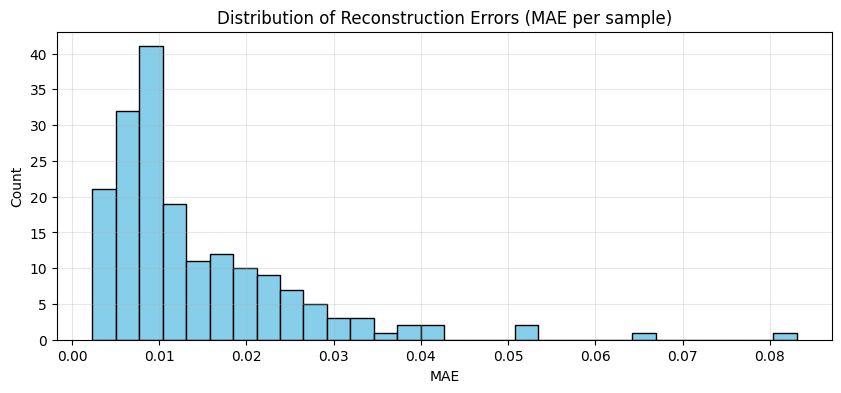

In [50]:
# ============================================================================
# GLOBAL VALIDATION METRICS
# ============================================================================

print(f"Calculating metrics for entire validation set ({len(val_df)} samples)...")

# 1. Prepare Full Input Tensor
# Extract all vectors using the same logic as before
all_vectors = val_df["kulfan_parameters"].apply(
  lambda p: np.concatenate([
    p["lower_weights"],     # Lower
    p["upper_weights"],     # Upper
    [p["TE_thickness"]],    # TE
    [p["leading_edge_weight"]] # LE
    ], axis=0)).to_list()

# Convert to Tensor and Normalize
all_tensor = tf.convert_to_tensor(all_vectors, dtype=tf.float32)
all_weights_raw = all_tensor[:, :24]
all_params_raw = all_tensor[:, 24:]
all_normalized = scaler.transform(all_weights_raw, all_params_raw)

# 2. Run Inference on the whole batch
# training=False ensures deterministic output (no sampling noise)
_, pred_w_norm, pred_p_norm = vae(all_normalized, training=False)

# 3. Reshape and Combine Predictions to match Input Shape (Batch, 26)
# VAE outputs weights as (Batch, 2, 12), we need flat (Batch, 24)
pred_w_flat = tf.reshape(pred_w_norm, [-1, 24]) 
pred_combined = tf.concat([pred_w_flat, pred_p_norm], axis=1)

# 4. Calculate MAE
# We use Keras built-in metric for efficiency
mae = tf.keras.losses.MeanAbsoluteError()
global_mae = mae(all_normalized, pred_combined).numpy()

print("\n" + "="*40)
print(f"GLOBAL MAE RESULTS (Model: {RUN_ID})")
print("="*40)
print(f"Validation MAE: {global_mae:.6f}")
print("="*40)

# Optional: Histogram of errors to check for outliers
errors = tf.reduce_mean(tf.abs(all_normalized - pred_combined), axis=1).numpy()
plt.figure(figsize=(10, 4))
plt.hist(errors, bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Reconstruction Errors (MAE per sample)")
plt.xlabel("MAE")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.show()